# Laborator 4

In cadrul acestui laborator o sa lucram cu blocurile de baza necesare construirii unor retele mai complexe. De interes sunt:


*   Residual Blocks
*   Inception Blocks

Pe langa acestea, o sa aplicam si augmentari generale de date care au rolul de a face modelul robust la variatii mici.



## Operatii Noi

Urmatoarele operatii vor fi folosite in cadrul laboratorului

Tensor shape: (batch,channels,dim1,dim2)


*  **torch.cat(tensors, dim=0).** Tensorii trebuie sa aiba aceleasi dim1,dim2, dar channels poate sa difere.
*  **torch.add(input, other)**. Tensorii trebuie sa aiba aceleasi dimensiune pe toate axele.





In [1]:
import numpy as np
import torch.nn as nn
import torch

dummy_input_tensor1 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1,5,100,100))  # Input random de marime 100x100 cu 5 canale

# Normal se concateneaza pe dimensiunea canalelor.
x = torch.cat([dummy_input_tensor1,dummy_input_tensor2],dim=1)
print(x.shape) # Numarul de canele_output = canale_input2 + canale_input1

dummy_input_tensor1 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale
dummy_input_tensor2 = torch.rand((1,3,100,100))  # Input random de marime 100x100 cu 3 canale

x = torch.add(dummy_input_tensor1,dummy_input_tensor2)
print(x.shape)

torch.Size([1, 8, 100, 100])
torch.Size([1, 3, 100, 100])


## Residual Block

In cadrul Resnet se utilizeaza residual connections / skip connections, care impreuna cu un path normal, ca cele implementate pana acum, formeaza un residual block.

<img src="https://user-images.githubusercontent.com/6086781/28494249-97e81166-6ef6-11e7-88b8-fa4aa184bc0b.png" alt="Drawing" style="height: 400px;"/>


### Cerinta 1 - **(3p)**

Implementati ResidualBlock. Acesta duce input tensor din ($c_{input}$,width,height) in  ($c_{out}$,width,height) sau  ($c_{out}$,width/2,height/2) in functie de stride. (Puteti implemnta oricare dintre variantele din imagine)




In [2]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F

class ResidualBlock(nn.Module):
  def __init__(self,input_channels=32,hidden_channels=64,output_channels=64,kernel_size=3,stride=1,activation=nn.ReLU()):
    super(ResidualBlock,self).__init__()
    layers = []

    # Your code here
    layers.append(nn.BatchNorm2d(input_channels))
    layers.append(activation)
    layers.append(nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2))

    layers.append(nn.BatchNorm2d(hidden_channels))
    layers.append(activation)
    layers.append(nn.Conv2d(in_channels=hidden_channels, out_channels=output_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2))

    self.net_normal = nn.Sequential(*layers)

    self.net_residual = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=1, stride=stride)

  def forward(self,x):
    x = torch.add(self.net_normal(x),self.net_residual(x))
    x = F.relu(x)
    return x

block = ResidualBlock(3,64,128,3,2,nn.ReLU())
x = torch.rand(size=(1,3,100,100))

# Should output torch.Size([1, 128, 50, 50])
print(block(x).shape)

torch.Size([1, 128, 50, 50])


## Inception Block

In cadrul GoogleNet/InceptionNet este folosit Inception Block, care este alcatuit din mai multe mini-retele putin diferite, care se unesc la finalul Inception Block

### Cerinta 2 - **(3p)**

Implementati Inception Block. Acesta trebuie sa duca un Tensor ($ch_{input}$,w,h) in ($ch_{out}$,w/2,h/2)

Punctaj:
- cate **0.5p** pentru fiecare path implementat corect **(4 * 0.5p = 2p)**
- codul ruleaza si rezultatul final este corect (**1p**)


<!-- ![InceptionBlock](https://drive.google.com/uc?export=view&id=11eiInGoQoytm_N0989v5oJnKpFrspUzk) -->

<img src="https://drive.google.com/uc?export=view&id=11eiInGoQoytm_N0989v5oJnKpFrspUzk" alt="Drawing" style="height: 200px; width:200px;"/>

In [3]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F


class InceptionBlock(nn.Module):
  def __init__(self,input_channels=32,kernel_size=3,stride=1,activation=nn.ReLU()):
    super(InceptionBlock,self).__init__()
    ## De sters
    layers = []
    layers.append(nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=1, stride=stride))
    layers.append(nn.BatchNorm2d(64))
    layers.append(activation)
    self.path1 = nn.Sequential(*layers)

    layers = []
    layers.append(nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=kernel_size//2))
    layers.append(nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=1, stride=1))
    layers.append(nn.BatchNorm2d(64))
    layers.append(activation)
    self.path2 = nn.Sequential(*layers)

    layers = []
    layers.append(nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=1, stride=1))
    layers.append(nn.BatchNorm2d(64))
    layers.append(activation)

    layers.append(nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, stride=stride, padding=1))
    layers.append(nn.BatchNorm2d(96))
    layers.append(activation)
    self.path3 = nn.Sequential(*layers)

    layers = []
    layers.append(nn.Conv2d(in_channels=input_channels, out_channels=64, kernel_size=1, stride=1))
    layers.append(nn.BatchNorm2d(64))
    layers.append(activation)

    layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1))
    layers.append(nn.BatchNorm2d(64))
    layers.append(activation)

    layers.append(nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=stride, padding=1))
    layers.append(nn.BatchNorm2d(32))
    layers.append(activation)
    self.path4 = nn.Sequential(*layers)

  def forward(self,x):
    x1 = self.path1(x)
    print(x1.shape)
    x2 = self.path2(x)
    print(x2.shape)
    x3 = self.path3(x)
    print(x3.shape)
    x4 = self.path4(x)
    print(x4.shape)
    x = torch.cat([x1,x2,x3,x4],1)
    return x

block = InceptionBlock(64,3,2,nn.ReLU())
x = torch.rand(size=(1,64,100,100))

# Should output torch.Size([1, 256, 50, 50])
print(block(x).shape)

torch.Size([1, 64, 50, 50])
torch.Size([1, 64, 50, 50])
torch.Size([1, 96, 50, 50])
torch.Size([1, 32, 50, 50])
torch.Size([1, 256, 50, 50])


## Instantierea seturilor de date

In acest laborator lucram cu un nou set de date. Este vorba de un dataset folosit in [aceasta competitie Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview), Pisici vs Caini.

***In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.***


## Crearea Dataloader-ului

In continuare, pentru a incarca date, sa o folosim un obiect mai complex, un Torch.utils.data.Dataset. Acesta are 3 functii importante:


*   __init__()
*   ____len____()
*  ____get_item____()



In [11]:
import zipfile
import os

zip_file_path_train = '/kaggle/input/dogs-vs-cats/train.zip'
zip_file_path_test = '/kaggle/input/dogs-vs-cats/test1.zip'
output_dir_train = '/kaggle/working/train'
output_dir_test = '/kaggle/working/test'

def extract(zip_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

extract(zip_file_path_train, output_dir_train)
extract(zip_file_path_test, output_dir_test)

In [32]:
import torch as t
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import random, os
random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

train_dir = '/kaggle/working/train/train'
test_dir = '/kaggle/working/test/test1'

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, width=128, height=128, transform=None):
        self.file_list = file_list
        self.img_size = (width, height)
        self.transform = transform
        
        self.images = []
        self.labels = []

        for img_path in self.file_list:
            img = Image.open(img_path)
            img = img.resize(self.img_size)
            img = np.array(img)

            label = img_path.split('/')[-1].split('.')[0]
            if label == 'dog':
                label = 1
            elif label == 'cat':
                label = 0

            self.images.append(to_tensor(img))
            self.labels.append(label)

        self.images = torch.stack(self.images) 
        self.labels = torch.tensor(self.labels)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Simply return the preloaded image and label from memory
        return self.images[idx], self.labels[idx]


Construire Dataset si vizualizare date.

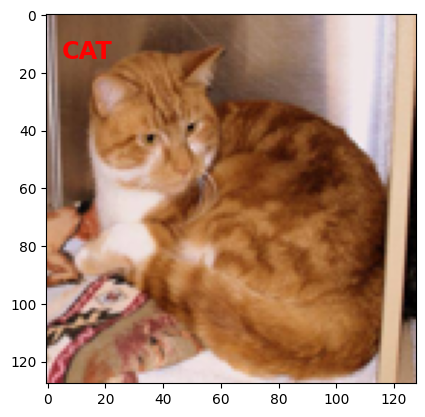

In [40]:
from IPython.display import clear_output
import time

train_test_proportion = .85

import glob

samples = glob.glob(os.path.join(train_dir, '*.jpg'))
random.shuffle(samples)

train_samples = samples[:int(train_test_proportion*len(samples))]
test_samples = samples[int(train_test_proportion*len(samples)):]

cats_dogs_train = CatsDogsDataset(train_samples)
cats_dogs_test = CatsDogsDataset(test_samples)

train_loader = DataLoader(cats_dogs_train, batch_size=64, shuffle=True, pin_memory=True, drop_last=True)
test_loader = DataLoader(cats_dogs_test, batch_size=64, shuffle=False, pin_memory=True)

see_examples = 10
for i, (imgs, label) in enumerate(train_loader):
    clear_output(wait=True)
    image = imgs[0].numpy().transpose(1, 2, 0)
    plt.imshow(image)
    plt.text(5, 15, "DOG" if label[0] else "CAT", fontsize ='xx-large', color='red', fontweight='bold')
    plt.show()

    if i >= see_examples - 1:
      break
    time.sleep(1)


### Cerinta 3 - **(4p)**

  1. Antrenati o retea convolutionala (o arhitectura la alegere din laboratorul 3) folosind acest dataset, pe GPU (https://pytorch.org/docs/stable/notes/cuda.html) **(1p)**
  2. Antrenati o retea de tip Resnet (folosind blocuri de tip Residual) **(1p)**
  3. Antrenati o retea de tip Inception (folosind blocuri de tip Inception)  **(1p)**
  4. Experimentati cu diferiti hyperparameters (numarul de layers, numarul de filtre/neuroni, etc.) **(1p)**


In [41]:
import torch.optim as optim


def test_acc(net: nn.Module, test_loader: DataLoader, device: torch.device):
    net.eval()

    total = 0
    correct = 0

    for test_images, test_labels in test_loader:
        
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)

        total += len(test_images)
        out_class = torch.argmax(net(test_images), dim=1)
        correct += torch.sum(out_class == test_labels)

    return correct / total * 100



def train_fn(epochs: int, train_loader: DataLoader, test_loader: DataLoader,
             net: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer, device: torch.device):
    # Iteram prin numarul de epoci
    for e in range(epochs):
        net.train()

        # Iteram prin fiecare batch din dataloader
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            
            out = net(images)
            loss = loss_fn(out, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print("Loss-ul la finalul epocii {} are valoarea {:.4f}".format(e, loss.item()))

        # Calculam acuratetea
        acc = test_acc(net, test_loader, device)
        print("Acuratetea la finalul epocii {} este {:.2f}%".format(e + 1, acc))


# LeNet

In [43]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5,5), stride=1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), stride=2)

    self.linear1 = nn.Linear(in_features=16*14*14, out_features=256)
    self.linear2 = nn.Linear(in_features=256, out_features=64)
    self.linear3 = nn.Linear(in_features=64, out_features=16)
    self.linear4 = nn.Linear(in_features=16, out_features=2)

    self.bn1 = nn.BatchNorm2d(6)
    self.bn2 = nn.BatchNorm2d(16)
    self.bn3 = nn.BatchNorm1d(256)
    self.bn4 = nn.BatchNorm1d(64)
    self.bn5 = nn.BatchNorm1d(16)

    self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.5)

  def forward(self,x):
    x = self.pool(self.bn1(self.relu(self.conv1(x))))
    x = self.pool(self.bn2(self.relu(self.conv2(x))))

    x = torch.flatten(x, start_dim=1)

    x = self.bn3(self.relu(self.linear1(x)))
    x = self.dropout(x)

    x = self.bn4(self.relu(self.linear2(x)))
    x = self.dropout(x)

    x = self.bn5(self.relu(self.linear3(x)))

    x = self.linear4(x)

    return x

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epochs = 20

lenet = LeNet().cuda()
lenet = torch.nn.SyncBatchNorm.convert_sync_batchnorm(lenet)
lenet = torch.nn.DataParallel(lenet, device_ids = [0,1]).to(device)

lenet_optimizer = optim.Adam(lenet.parameters(), lr=1e-3)
lenet_optimizer.zero_grad()
loss_fn = nn.CrossEntropyLoss().cuda()

train_fn(epochs, train_loader, test_loader, lenet, loss_fn, lenet_optimizer, device)

Loss-ul la finalul epocii 0 are valoarea 0.5930
Acuratetea la finalul epocii 1 este 68.93%
Loss-ul la finalul epocii 1 are valoarea 0.5397
Acuratetea la finalul epocii 2 este 66.77%
Loss-ul la finalul epocii 2 are valoarea 0.4885
Acuratetea la finalul epocii 3 este 72.27%
Loss-ul la finalul epocii 3 are valoarea 0.4389
Acuratetea la finalul epocii 4 este 77.52%
Loss-ul la finalul epocii 4 are valoarea 0.5188
Acuratetea la finalul epocii 5 este 73.36%
Loss-ul la finalul epocii 5 are valoarea 0.3448
Acuratetea la finalul epocii 6 este 74.48%
Loss-ul la finalul epocii 6 are valoarea 0.4093
Acuratetea la finalul epocii 7 este 75.12%
Loss-ul la finalul epocii 7 are valoarea 0.4976
Acuratetea la finalul epocii 8 este 76.16%
Loss-ul la finalul epocii 8 are valoarea 0.3019
Acuratetea la finalul epocii 9 este 78.83%
Loss-ul la finalul epocii 9 are valoarea 0.2433
Acuratetea la finalul epocii 10 este 75.63%
Loss-ul la finalul epocii 10 are valoarea 0.2532
Acuratetea la finalul epocii 11 este 79.